# Summary Quality Metrics: Original vs Generated

Comparing the **original summaries** (from master_resumes_original.jsonl) with our **generated summaries** using the same metrics.

In [ ]:
# Setup: Load both original and generated summaries
import json
import numpy as np

with open('original_summaries.json', 'r', encoding='utf-8') as f:
    original_summaries = json.load(f)

with open('generated_summaries.json', 'r', encoding='utf-8') as f:
    generated_summaries = json.load(f)


## Metric 1: Word Count Comparison

Are the summaries a reasonable length? Compare original vs generated.

In [36]:
# Word counts for both
original_wc = [len(s.split()) for s in original_summaries.values() if s.strip()]
generated_wc = [len(s.split()) for s in generated_summaries.values() if s.strip()]

print("WORD COUNT COMPARISON")
print(f"{'Metric':<20} {'Original':<15} {'Generated':<15}")
print("-"*50)
print(f"{'Average':<20} {np.mean(original_wc):.0f} words{'':<5} {np.mean(generated_wc):.0f} words")
print(f"{'Min':<20} {np.min(original_wc):<15} {np.min(generated_wc):<15}")
print(f"{'Max':<20} {np.max(original_wc):<15} {np.max(generated_wc):<15}")
print(f"{'Too short (<30)':<20} {sum(1 for w in original_wc if w < 30):<15} {sum(1 for w in generated_wc if w < 30):<15}")

WORD COUNT COMPARISON
Metric               Original        Generated      
--------------------------------------------------
Average              20 words      60 words
Min                  1               20             
Max                  109             90             
Too short (<30)      4685            2              


## Metric 2: Content Similarity to Resume (TF-IDF Cosine Similarity)

How well does each summary reflect the actual resume content?

In [37]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load resume data
df = pd.read_csv('cleaned_resumes.csv')

# Combine resume fields as the "source" text
df['resume_text'] = df['experience'].fillna('') + " " + df['skills'].fillna('') + " " + df['projects'].fillna('')

# Map summaries to dataframe
df['original_summary'] = df.index.astype(str).map(original_summaries).fillna('')
df['generated_summary'] = df.index.astype(str).map(generated_summaries).fillna('')

# Calculate similarity for sample (first 1000)
tfidf = TfidfVectorizer(stop_words='english', max_features=3000)
sample = df.head(1000)

orig_sims, gen_sims = [], []
for idx, row in sample.iterrows():
    if row['resume_text'].strip() and row['original_summary'].strip():
        mat = tfidf.fit_transform([row['resume_text'], row['original_summary']])
        orig_sims.append(cosine_similarity(mat[0:1], mat[1:2])[0][0])
    if row['resume_text'].strip() and row['generated_summary'].strip():
        mat = tfidf.fit_transform([row['resume_text'], row['generated_summary']])
        gen_sims.append(cosine_similarity(mat[0:1], mat[1:2])[0][0])

print("CONTENT SIMILARITY TO RESUME")
print(f"{'Metric':<20} {'Original':<15} {'Generated':<15}")
print("-" * 40)
print(f"{'Mean Similarity':<20} {np.mean(orig_sims):.3f}{'':<10} {np.mean(gen_sims):.3f}")

CONTENT SIMILARITY TO RESUME
Metric               Original        Generated      
----------------------------------------
Mean Similarity      0.055           0.154


## Distribution Visualization

Visual comparison of both metrics.

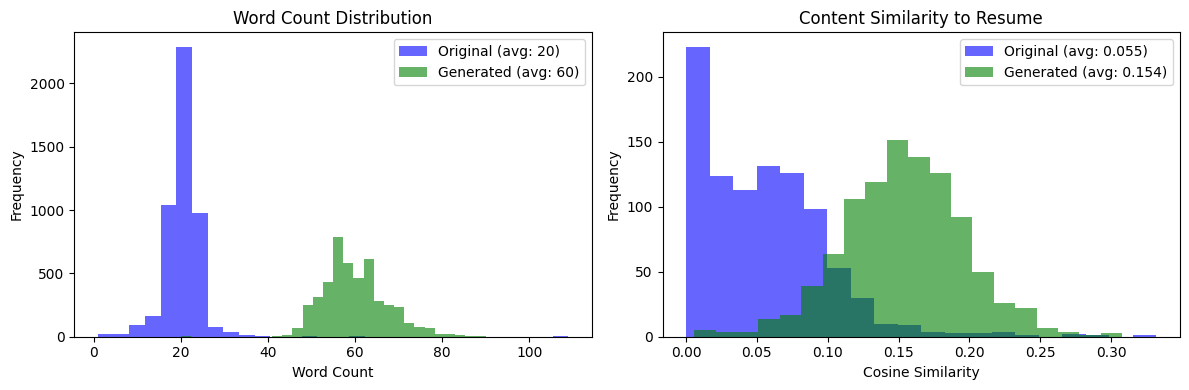

In [38]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Word Count Distribution
axes[0].hist(original_wc, bins=30, alpha=0.6, label=f'Original (avg: {np.mean(original_wc):.0f})', color='blue')
axes[0].hist(generated_wc, bins=30, alpha=0.6, label=f'Generated (avg: {np.mean(generated_wc):.0f})', color='green')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Word Count Distribution')
axes[0].legend()

# Similarity Distribution
axes[1].hist(orig_sims, bins=20, alpha=0.6, label=f'Original (avg: {np.mean(orig_sims):.3f})', color='blue')
axes[1].hist(gen_sims, bins=20, alpha=0.6, label=f'Generated (avg: {np.mean(gen_sims):.3f})', color='green')
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Content Similarity to Resume')
axes[1].legend()

plt.tight_layout()
plt.show()